# Introduction to Neural Networks


** Ecole Centrale Nantes **

** Diana Mateus **


** Participants : **
### So Onishi


## General description
In this lab we will create a simple classifier based on neural networks. We will progress in two parts:
- In the first part, and to better understand the involved operations, we will create a single-neuron model and optimize its parameters "by hand". For this first part we will only use the **Numpy** library
- We will then build a CNN with the built-in **Keras** module from **tensorflow**. Tensorflow is already installed in the university computers. If using your own computer you should have already installed **tensorflow** or use **collab** online platform.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Loading the dataset
Start by runing the following lines to load and visualize the data.

In [2]:
# UNCOMMENT IF USING COLAB
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = '/content/drive/MyDrive/Colab Notebooks/2022-2023 Machine Learning/05-neural networks/'

In [3]:
def load_dataset(IMDIR):
    train_dataset = h5py.File(IMDIR+'dataset/train_catvnoncat.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) # access data set named "train_set_x" in HDF5, [:] means we can access all data in HDF5 as array(配列)
    train_y = np.array(train_dataset["train_set_y"][:])

    # for check value
    # print(f"Train X:\n{train_x}")
    # print(f"Train Y:\n{train_y}")

    test_dataset = h5py.File(IMDIR+'dataset/test_catvnoncat.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:])

    # print(f"Before:\n{train_y}")
    train_y = train_y.reshape((1, train_y.shape[0])) # change dimension from 1 to 2 (次元を２にしている) -> suitable for machine learning flame work
    # print(f"After:\n{train_y}")
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y, classes

# print("-------- Before Setting --------")
IMDIR = "./"
train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)

# print("-------- After Setting --------")
# print(f"Train X:\n{train_x}")
# print(f"Train Y:\n{train_y}")

#### Visualize data

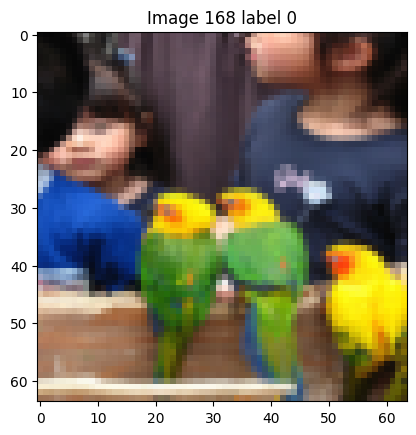

Train X shape: (209, 64, 64, 3)
We have 209 images of dimensionality 64x64x3


In [4]:
# run several times to visualize different data points
# the title shows the ground truth class labels (0=no cat , 1 = cat)
index = np.random.randint(low=0,high=train_y.shape[1])
plt.imshow(train_x[index])
plt.title("Image "+str(index)+" label "+str(train_y[0,index]))
plt.show()
print ("Train X shape: " + str(train_x.shape))
print ("We have "+str(train_x.shape[0]),
       "images of dimensionality "
       + str(train_x.shape[1])+ "x"
       + str(train_x.shape[2])+ "x"
       + str(train_x.shape[3]))

#### Preprocessing
In the following lines we vectorize the images (Instead of a 2-D image we will give as input to the models a 1-D vector). The normalization makes the image intensities be between 0 and 1, and converts the images to floats.

In [19]:
train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)
print ("Original train X shape: " + str(train_x.shape)) # reshape is which gives a new shape to an array without changing its data.
print ("Original test X shape: " + str(test_x.shape))
print(f"Train X Shape[0]:{train_x.shape[0]}\n")

# after vectorize
train_x = train_x.reshape(train_x.shape[0], -1).T # "-1" means decide size of dimension automatically, .T change row and column
test_x = test_x.reshape(test_x.shape[0], -1).T
print ("Train X shape: " + str(train_x.shape))
print ("Train Y shape: " + str(test_y.shape))
print ("Test X shape: " + str(test_x.shape))
print ("Test Y shape: " + str(test_y.shape))

Original train X shape: (209, 64, 64, 3)
Original test X shape: (50, 64, 64, 3)
Train X Shape[0]:209

Train X shape: (12288, 209)
Train Y shape: (1, 50)
Test X shape: (12288, 50)
Test Y shape: (1, 50)


In [6]:
# The normalization makes the image intensities be between 0 and 1, and converts the images to floats.
print("----- Before Initialize -----\n","Train[1000][208]:",train_x[1000][208])
train_x = train_x/255. # Pixel value of image data represents 0 ~ 255
print("----- After Initialize -----\n", "Train[10000][208]:",train_x[1000][208], "\n")

# normalize test set
test_x = test_x/255.

print(f"Train X:{train_x}")
print(f"Test Y:{test_y}")

print(f"\nClasses labels:{classes}")

----- Before Initialize -----
 Train[1000][208]: 43
----- After Initialize -----
 Train[10000][208]: 0.16862745098039217 

Train X:[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]
Test Y:[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]

Classes labels:[b'non-cat' b'cat']


In [28]:
for i in range(10):
    print(f"{i}番目の答え{test_y[0][i]}")

0番目の答え1
1番目の答え1
2番目の答え1
3番目の答え1
4番目の答え1
5番目の答え0
6番目の答え1
7番目の答え1
8番目の答え1
9番目の答え1


### 1. Classification with a single neuron


**a)** Fill-in the following three functions to define the single neuron model (a single neuron in the hidden layer):
- A function **initialize_parameters**, which given the number of desired weights ```dim```  it inizializes the neuron parameters.  
> The function will initialize:
> * the model's weights $\mathbf{w}$ by randomly, by sampling small values from a normal distribution (**Hint:** np.random.randn).
> * the bias $b$ with 0.
What is the number of weights required? pass this information as a parameter to the function.
- A function **sigmoid** that computes the sigmoid activation function
- A function **neuron** that given an input vector, the weights and bias, computes the output of the single neuron model

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# for check function
# print(sigmoid(0))

In [8]:
def initialize_parameters(dim): # dim are the number of desired weights
    w = np.random.randn(dim, 1) * 0.01
    b = 0
    return w, b

In [9]:
def neuron(w, b, x):
    pred_y = np.dot(w.T, x) + b
    return sigmoid(pred_y)

**b)** **Forward Pass:**
Use the three functions above to compute a first forward pass for the input matrix $X$ containing the loaded dataset, for some initialization of the weights and bias.

 \begin{align}
 Y_{\rm pred}=\sigma(w^\top X+b) = [y_{\rm pred}^{(1)},y_{\rm pred}^{(2)},\dots,y_{\rm pred}^{(m)}]
 \end{align}


In [10]:
# if number of features are 12288
dim = 12288
w, b = initialize_parameters(dim)

pred_y = neuron(w, b, train_x)
print(f"Y Prediction:{pred_y}")

Y Prediction:[[0.51736493 0.49838114 0.62023058 0.47070622 0.55448071 0.60152213
  0.51999217 0.63219548 0.66146491 0.48372907 0.62464926 0.63815201
  0.62841317 0.47789438 0.57328619 0.74451337 0.77772617 0.69107598
  0.58946634 0.47228579 0.5913404  0.54253645 0.67813634 0.74402468
  0.64958592 0.50490841 0.64103084 0.56672654 0.48865412 0.55738347
  0.66369178 0.69282788 0.69934037 0.63176135 0.45111778 0.66283568
  0.69749133 0.55795139 0.50169062 0.62862903 0.43008826 0.44226577
  0.6317825  0.5426592  0.66323594 0.59290535 0.62419673 0.63226853
  0.46809822 0.63502641 0.67510403 0.66327616 0.59468722 0.68846061
  0.62543419 0.72794423 0.61111512 0.77635102 0.53579441 0.58012978
  0.57640018 0.59612175 0.65858788 0.50126151 0.65925763 0.54087535
  0.63324043 0.57863463 0.63577003 0.53764202 0.57768432 0.51092389
  0.60835673 0.60397489 0.54350351 0.64261801 0.52688543 0.58891801
  0.57096636 0.52563642 0.58643286 0.63817531 0.52649449 0.63977215
  0.64292375 0.68320869 0.59476732 

**c) Cost estimation:**

We will use a binary cross-entropy loss, so that the empirical risk can be computed as:
\begin{align}
E = - \frac{1}{m} \sum_{i=1}^m
y^{(i)} \log(y_{\rm pred}^{(i)}) +
(1-y^{(i)}) \log(1-y_{\rm pred}^{(i)})
\end{align}

 The following cross-entropy function should give as result the **scalar** cost value computed over the entire dataset

In [11]:
print(train_y)
print(train_y.shape)

def crossentropy(train_y, pred_y, epsilon = 1e-8):
    m = train_y.shape[1]
    cost = -1/m * np.sum(train_y * np.log(pred_y + epsilon) + (1 - train_y) * np.log(1 - pred_y + epsilon))
    cost = np.squeeze(cost) # change result into scaler
    return cost

cost = crossentropy(train_y,pred_y)
print(f"Cost:{cost}")

[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]
(1, 209)
Cost:0.7943597169454851


**d) Back propagation:**

After initializing the parameters and doing a forward pass, we need to backpropagate the cost by computing the gradient with respect to the model parameters to later update the weights

\begin{align}
\frac{\partial E}{\partial w} = \\
\frac{\partial E}{\partial b} =
\end{align}

See a demonstration of the gradient computation in
https://en.wikipedia.org/wiki/Cross_entropy

Fill-in the backpropagation function which receives as input the the training set (X,Y), as well as the current predictions and returns the gradients updates for the weights and bias

Hint: When the error is computed for several samples simultaneously, the gradient is averaged over the contribution of different samples.


In [12]:
# X: input
# Y: actual label
# Ypred: predict label
print(train_x.shape)

def backpropagate(X, Y, Ypred):
    m = X.shape[1]

    # calculate base of repair
    delta_o = (Ypred - Y) * Ypred * (1 - Ypred)

    #find gradient (back propagation)
    dw = np.dot(X, delta_o.T) / m
    db = np.sum(delta_o) / m
    grads = {"dw": dw,
             "db": db}

    return grads

(12288, 209)


**e) Optimization**
After initializing the parameters, computing the cost function, and calculating gradients, we can now update the parameters using gradient descent. Use the functions implemented above to fill_in the "gradient_descent" function that optimizes the parameters given a training set X, Y, a fixed number of iterations, and a learning_rate. Store and plot the value of the loss function at each iteration

In [13]:
def gradient_descent(X, Y, iterations, learning_rate):
    costs = []
    w, b = initialize_parameters(X.shape[0])

    for i in range(iterations):
        Ypred = neuron(w, b, X)
        cost  = crossentropy(Y, Ypred)
        grads = backpropagate(X, Y, Ypred)

        #update parameters
        w -= learning_rate * grads["dw"]
        b -= learning_rate * grads["db"]
        costs.append(cost)

        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return w,b, costs

w, b, costs = gradient_descent(train_x,train_y,iterations=2000, learning_rate = 0.005)

Cost after iteration 0: 0.716592
Cost after iteration 100: 0.591748
Cost after iteration 200: 0.553589
Cost after iteration 300: 0.525156
Cost after iteration 400: 0.501991
Cost after iteration 500: 0.482254
Cost after iteration 600: 0.464982
Cost after iteration 700: 0.449599
Cost after iteration 800: 0.435724
Cost after iteration 900: 0.423090
Cost after iteration 1000: 0.411498
Cost after iteration 1100: 0.400797
Cost after iteration 1200: 0.390867
Cost after iteration 1300: 0.381612
Cost after iteration 1400: 0.372951
Cost after iteration 1500: 0.364820
Cost after iteration 1600: 0.357163
Cost after iteration 1700: 0.349932
Cost after iteration 1800: 0.343088
Cost after iteration 1900: 0.336595


**f) Plot the training loss curve**
Plot the evolution of the loss against the iterations

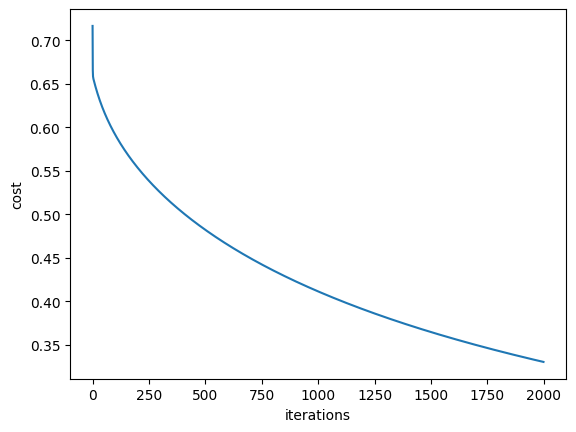

In [14]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

**g) Prediction**
Use the optimized parameters to make predictions both for the train and test sets and compute the accuracy for each. What do you observe?

In [15]:
def predict(w, b, X):
    y_pred = neuron(w, b, X)

    return y_pred

# predict
train_pred_y = predict(w, b, train_x)
test_pred_y = predict(w, b, test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))


Train Acc: 73.43434498663208 %
Test Acc: 60.14647301727813 %


**h)Choose learning rate on a validation set** Use 10% of the training data as validation to choose the learning rate. What are the best results you can obtain? (use only the validation data to choose, buy repport the accuracy on the train and test data)


In [16]:
# number of practice data set
num_train_examples = train_x.shape[1]

# size of validation data
num_val_examples = int(num_train_examples * 0.1)

# divide data
val_x = train_x[:, :num_val_examples]
val_y = train_y[:, :num_val_examples]
train_x = train_x[:, num_val_examples:]
train_y = train_y[:, num_val_examples:]

# check format
print("New Train X shape:", train_x.shape)
print("New Train Y shape:", train_y.shape)
print("Validation X shape:", val_x.shape)
print("Validation Y shape:", val_y.shape)


New Train X shape: (12288, 189)
New Train Y shape: (1, 189)
Validation X shape: (12288, 20)
Validation Y shape: (1, 20)


In [17]:
# to do
# Ronaldo picture